### Author: Louie Alexander 
### Title: Tutorial of `randomForest` R package
### Updated: Nov 14, 2022

# Tutorial of `randomForest` R package

This tutorial serves as an introduction to the `randomForest` R package and its applications for bioinformatics.  I demonstrate how to use random forest on a heart disease dataset to classify severity of disease, and document the predictors that have the greatest impact in the model.

The dataset is pulled from the Cleveland heart disease dataset, archived by the University of California Irvine (http://archive.ics.uci.edu/ml/datasets/Heart+Disease.)

In [1]:
#Install randomForest R package
if (!require(randomForest)) { install.packages("randomForest")}
if (!require(tidyverse)) { install.packages("tidyverse")}

library(randomForest)
library(tidyverse)

Loading required package: randomForest

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘randomForest’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: tidyverse

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.7      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:dplyr’:

    combine


The following ob

In [2]:
#Grab dataset from the UCI archive
heartDiseaseData <- read.table("http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", sep = ",", header = FALSE)

#Add variable names to features
names(heartDiseaseData) <- c("Age", "Sex", "ChestPain","restBP", "serCholesterol", "restBloodSugar", "restECG", "maxHeartRate", "ExerciseAngina", "oldPeak", "slope", "Fluoroscopy", "thal", "HeartDiseaseClass")

#Show dataset
head(heartDiseaseData) 
dim(heartDiseaseData) #303 samples x 13 features and 1 label

,Age,Sex,ChestPain,restBP,serCholesterol,restBloodSugar,restECG,maxHeartRate,ExerciseAngina,oldPeak,slope,Fluoroscopy,thal,HeartDiseaseClass
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
6,56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0


[1] 303  14

Notice that Fluoroscopy and thal are classified as "character" variables (strings) since they have missing values represented by "?"
We will address this below by changing these to NA which is the "missing value" in R.  
The classification of heart disease was diagnosed by blood vessel narrowing and encoded as follows:

0: no sign of narrowing

1 to 4: significant narrowing (heart disease)

For simplicity, let's make this classification binary: 0 = no heart disease; 1 = heart disease

In [3]:
#Make HeartDiseaseClass binary: 0 == no heart disease; 1 == heart disease (diagnosed by blood vessel narrowing)
#This ifelse statement checks the value in HeartDiseaseClass for every sample.  For samples classified as 2, 3, or 4, it changes the classification to 1.  It leaves all other classfications the same
heartDiseaseData <- heartDiseaseData %>% mutate(HeartDiseaseClass = ifelse(HeartDiseaseClass > 0, 1, HeartDiseaseClass)) 

#Remove samples with missing data in Fluoroscopy and thal
heartDiseaseData <- heartDiseaseData %>% filter(Fluoroscopy != "?" & thal != "?") 
dim(heartDiseaseData)

#Now make these numeric
heartDiseaseData$Fluoroscopy <- as.numeric(heartDiseaseData$Fluoroscopy)
heartDiseaseData$thal <- as.numeric(heartDiseaseData$thal)

#Ensure label is a factor so that randomForest treats it as the outome
heartDiseaseData$HeartDiseaseClass <- as.factor(heartDiseaseData$HeartDiseaseClass)

[1] 297  14

The `randomForest` function accepts the dataset of features and label.  Since random forest does not perform with missing data, the `na.omit` argument omits missing data.  The formula `HeartDiseaseClass ~.` uses all features as predictors of the label variable ("HeartDiseaseClass").  `ntree` is the number of trees generated and compiled.  A higher number of iterations help the model better determine the relationship between the predictors and label.  
`importance = TRUE` is an additional argument that reports metrics quantifying the relative impact of each predictor on the algorithm (Mean Decrease Accuracy and Mean Decrease Gini.)  These are explained more below.

In [5]:
#set Random Seed
set.seed(425)

#Evaluate model using full dataset
classHD <- randomForest(HeartDiseaseClass ~., importance = TRUE, na.action = na.omit, data=heartDiseaseData, mtry=3, ntree=2000)
falsePos = round(classHD$confusion[1,3], 4) * 100
falseNeg = round(classHD$confusion[2,3], 4) * 100

#View summary below.  Note OOB error and mean decrease Gini
print(classHD) 
paste0(cat("\nFalse Positive Rate:", falsePos, "False Negative Rate:", falseNeg))


Call:
 randomForest(formula = HeartDiseaseClass ~ ., data = heartDiseaseData,      importance = TRUE, mtry = 3, ntree = 2000, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 3

        OOB estimate of  error rate: 17.17%
Confusion matrix:
    0   1 class.error
0 138  22   0.1375000
1  29 108   0.2116788

False Positive Rate: 13.75 False Negative Rate: 21.17

character(0)

Since our classification task was binary, the confusion matrix above gives the false positive rate, false negative rate, and out-of-bag error rate.  

Additionally, with random forest, we can report predictor variables that had the greatest impact on the model's accuracy and error.  These metrics are called Mean Decrease Accuracy (MDA) and Mean Decrease Gini (MDG,) representing accuracy and error respectively.  For each metric, a high value indicates the predictor has a high impact on accuracy or error.

Random forest models represent the composite of many decisions trees that all try to classify samples using only some of the predictors.  MDA represents the average accuray lost in models that **don't** include the variable.  

MDG is based off the Gini impurity metric.  In a single decision tree, Gini impurity is the proportion of records that were misclassified, and a low Gini metric represents low error.  For a random forest model, the Gini impurity is measured for each predictor across iterations of decision trees, and the Gini impurity (error) decreases.  Therefore, a large MDG means that trees including a given predictor had low error rates.   

In [6]:
print(importance(classHD))

                        0         1 MeanDecreaseAccuracy MeanDecreaseGini
Age            13.7612994 10.162260           17.2825065        12.796130
Sex            21.4246205 10.322372           22.5222348         4.618993
ChestPain      22.9717477 34.652687           38.4034638        17.266436
restBP          2.8177107  1.820826            3.3907947        10.764889
serCholesterol  2.9970132 -4.026612           -0.3373592        11.752417
restBloodSugar  3.4447451 -3.583320            0.1001967         1.338129
restECG        -0.2699883  2.309877            1.2816203         2.913114
maxHeartRate   18.3877921 10.337904           19.9228918        17.187013
ExerciseAngina  8.6927558 19.203384           19.5118367         7.477287
oldPeak        18.3390415 22.765249           29.1137932        15.632901
slope           5.0644434 16.559974           16.2714798         6.610688
Fluoroscopy    42.4679856 38.277859           51.8910414        18.028204
thal           37.4032130 34.331245   

The largest MDA and MDG values were for the variables: `thal`, `Fluoroscopy`, and `ChestPain`.  This means they were the most helpful predictors for the model to increase its accuracy and reduce its error.  We can visualize and sort the MDA and MGA ina  variable importance plot using the `varImpPlot` function below. 

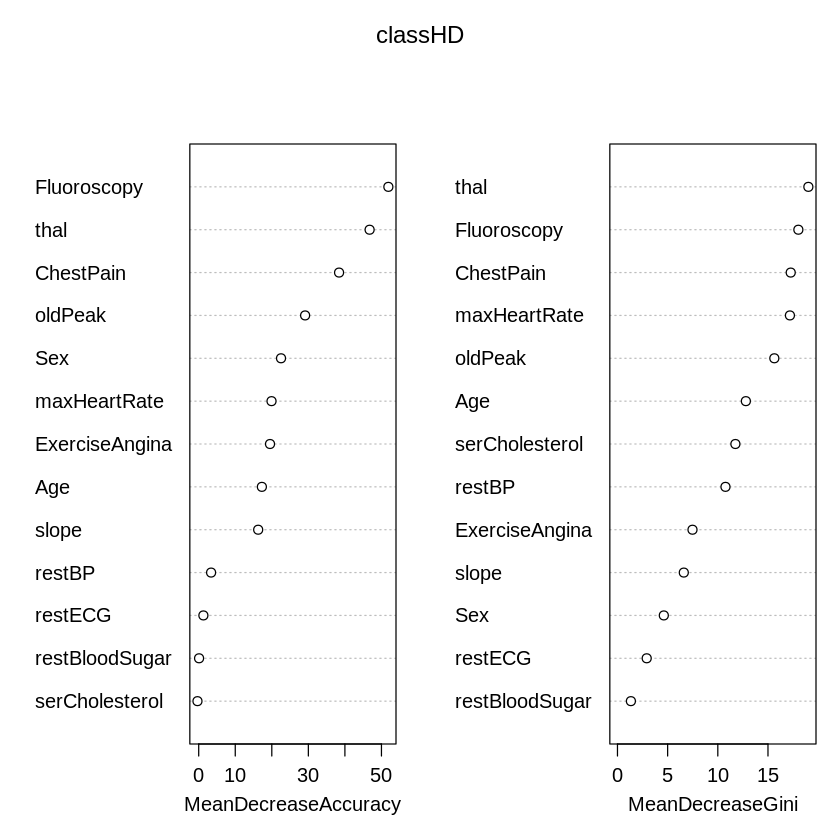

In [7]:
varImpPlot(classHD, sort = TRUE)

Notably, `Fluoroscopy`, `thal`, and `ChestPain` had the highest MDA and MDG of the predictors.  The MDA of these predictors is pretty high compared to the MDG.

In [17]:
set.seed(425)

#split into testing and training set and repeat.  Make sure to show important predictor variables
ss = nrow(heartDiseaseData)

trainN = ceiling(0.7 * ss) #70% of samples used to train
trainSamples <- sample(ss, size = trainN) #these hold row numbers of samples

Xtrain <- heartDiseaseData[trainSamples, ] #make training set (and keep label in)

#The other 30% should be used for validation and test datasets
validTestData <- heartDiseaseData[-trainSamples, ]

ssValid = nrow(validTestData)
validN = ceiling(0.15 * ss)

validSamples <- sample(ssValid, size = validN)
Xvalid <- validTestData[validSamples, ] 
yvalid <- Xvalid[, 14]
Xvalid <- Xvalid[, -14]

#Get test data set
Xtest <- validTestData[-validSamples, ]
ytest <- Xtest[, 14] #pull out label from testing data
Xtest <- Xtest[, -14]

Note that in the `randomForest` function, we need to choose values to use for the `mtry` and `ntrees` parameters.  We can determine 'optimal' values for these parameters by using a grid search function.  This function compares models made using different combinations of these parameters and reports the 'best' combination.

mtry = 3  OOB error = 20% 
Searching left ...
mtry = 2 	OOB error = 15.56% 
0.2222222 0.1 
mtry = 1 	OOB error = 15.56% 
0 0.1 
Searching right ...
mtry = 6 	OOB error = 20% 
-0.2857143 0.1 


      mtry         OOBError     
 Min.   :1.00   Min.   :0.1556  
 1st Qu.:1.75   1st Qu.:0.1556  
 Median :2.50   Median :0.1778  
 Mean   :3.00   Mean   :0.1778  
 3rd Qu.:3.75   3rd Qu.:0.2000  
 Max.   :6.00   Max.   :0.2000  

mtry = 3  OOB error = 20% 
Searching left ...
mtry = 2 	OOB error = 17.78% 
0.1111111 0.1 
mtry = 1 	OOB error = 15.56% 
0.125 0.1 
Searching right ...
mtry = 6 	OOB error = 20% 
-0.2857143 0.1 


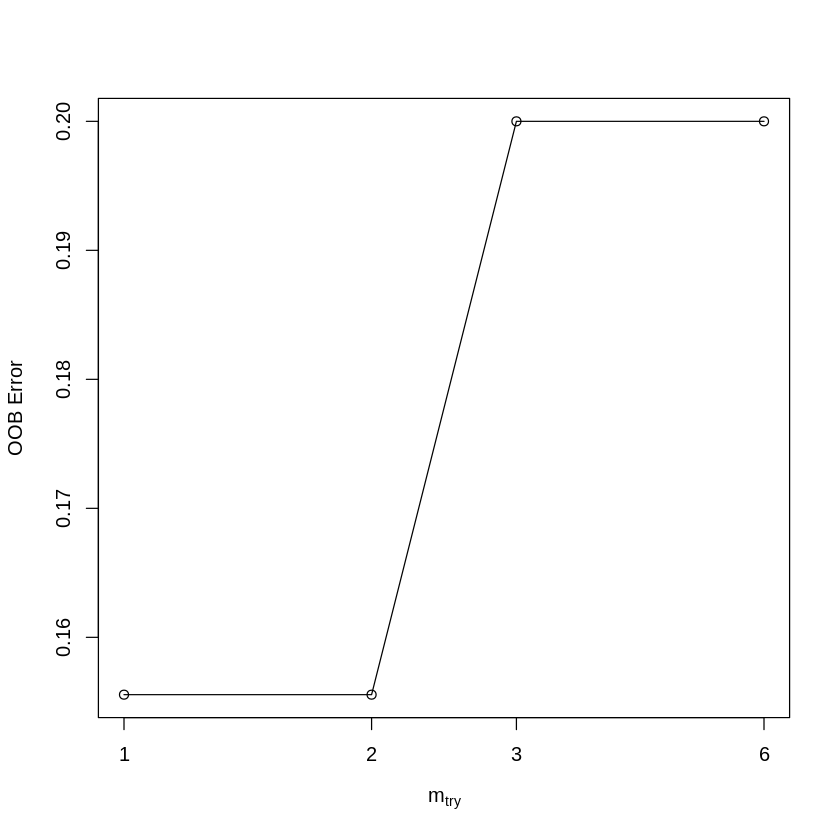

      mtry         OOBError     
 Min.   :1.00   Min.   :0.1556  
 1st Qu.:1.75   1st Qu.:0.1722  
 Median :2.50   Median :0.1889  
 Mean   :3.00   Mean   :0.1833  
 3rd Qu.:3.75   3rd Qu.:0.2000  
 Max.   :6.00   Max.   :0.2000  

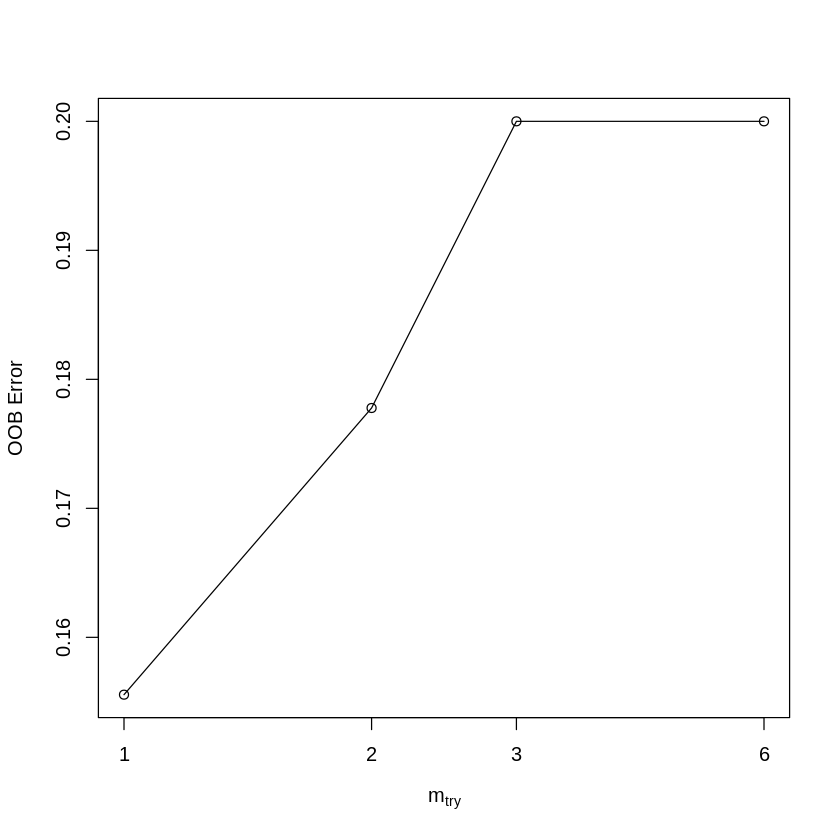

In [18]:
#Use tuneRF to get the best mtry parameter
params <- tuneRF(x = Xvalid, y = yvalid, na.action = na.omit, ntreeTry = 2000, mtryStart = 3, improve = 0.1)
summary(params)

params2 <- tuneRF(x = Xvalid, y = yvalid, na.action = na.omit, ntreeTry = 5000, mtryStart = 3, improve = 0.1)
summary(params2)

#mtry of 1 doesn't fully utilize the power of random forest, so mtry = 2 will be used
m = 2

In [19]:
set.seed(425)

#Train model using training data
trainHD <- randomForest(HeartDiseaseClass ~., importance = TRUE, na.action = na.omit, data=Xtrain, mtry = m, ntree=2000)
print(trainHD)

falsePos = round(trainHD$confusion[1,3], 4) * 100
falseNeg = round(trainHD$confusion[2,3], 4) * 100
paste0(cat("\nFalse Positive Rate:", falsePos, "False Negative Rate:", falseNeg))


Call:
 randomForest(formula = HeartDiseaseClass ~ ., data = Xtrain,      importance = TRUE, mtry = m, ntree = 2000, na.action = na.omit) 
               Type of random forest: classification
                     Number of trees: 2000
No. of variables tried at each split: 2

        OOB estimate of  error rate: 17.31%
Confusion matrix:
   0  1 class.error
0 94 15   0.1376147
1 21 78   0.2121212

False Positive Rate: 13.76 False Negative Rate: 21.21

character(0)

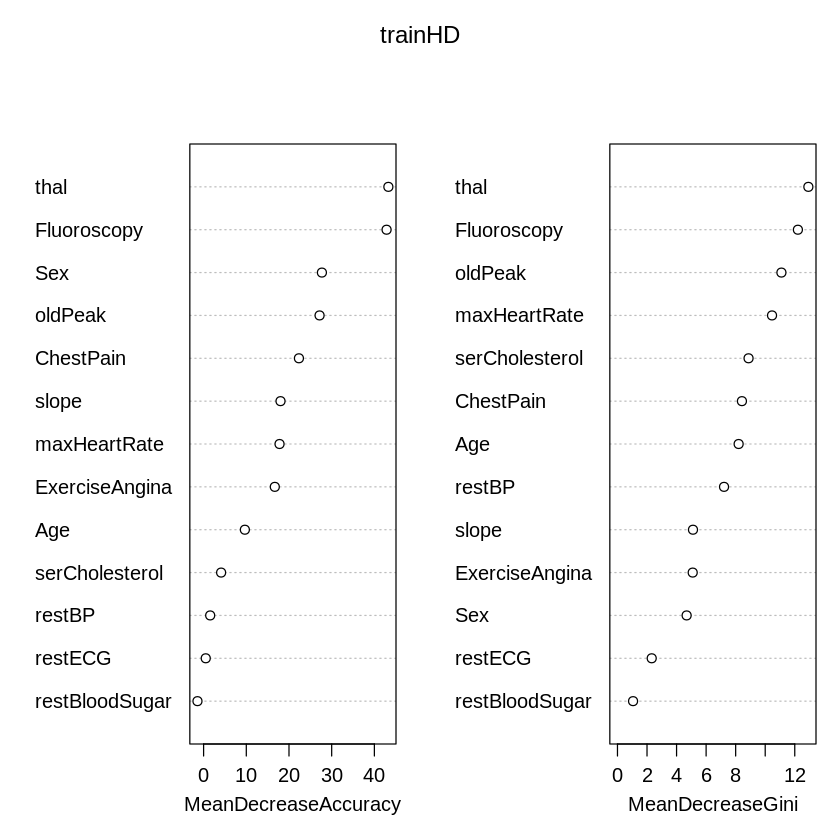

In [20]:
varImpPlot(trainHD, sort = TRUE)

In [23]:
#Evaluate predictions of test data
predictions <- predict(trainHD, newdata = Xtest, type = "response") #give predict function the test data without labels
table(predictions, ytest) #compare predicted labels to real labels

accuracyTest = sum(predictions == ytest, na.rm = TRUE)/length(ytest)
error = 1 - accuracyTest
paste0(cat("The accuracy of the model on test data was:", round(accuracyTest, 3) * 100, "%"))
paste0(cat("The error of the model on test data was:", round(error, 3) * 100, "%"))

           ytest
predictions  0  1
          0 26  3
          1  3 12

The accuracy of the model on test data was: 86.4 %

character(0)

The error of the model on test data was: 13.6 %

character(0)

# Conclusion
The model works very well on the test data- the model has high accuracy.  From variable importance plots, we can conlude that `thal` and `Fluoroscopy` are important predictors of heart disease, given that they greatly improve accuracy and decrease error when included in decision trees.  `oldPeak` also had high on MDA and MDG relative to other variables.  Interestingly, `ChestPain` had high MDA and MDG when a model was trained on all data (chunk 6,) but had lower importance in the model trained with the training subset.  A larger dataset or higher `mtry` value could improve the model's consistency in evaluating importance.    